# Preliminaries

In [1]:
#@title Install libraries
%%capture
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install vincenty

In [2]:
#@title Mount google drive
from google.colab import drive
drive.mount('/gdrive')

import os
import sys

os.chdir(r'/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB')
if "." not in sys.path:
  sys.path.append(".")

Mounted at /gdrive


In [3]:
#@title GPU/CPU, RAM info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU')
else:
  print(gpu_info)

# Check GPU is available
# https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
# import tensorflow as tf
# tf.test.gpu_device_name()

# List of CPU
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


No GPU


In [4]:
#@title import libraries
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import time
import copy

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import catboost
import tensorflow as tf

# My helpers
import helpers.run_model as run_model
import helpers.tune_model as tune_model
import helpers.data_prep as data_prep

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set(color_codes=True)

# Reimport after change
import importlib
# importlib.reload(run_model)  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset

In [8]:
#@title Load dataset
DATA_DIR = 'data/'
SEED_FOR_SPLIT = 0  # random_state for split
#x_train = pickle.load(open(DATA_DIR + 'x_train.beforeOneHot.pickle', 'rb'))
x_train = pd.read_csv(DATA_DIR+'prepared/x_train.csv.zip', compression='zip')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')
x_test = pd.read_csv(DATA_DIR+'prepared/x_test.csv.zip', compression='zip')

print('shapes: ', x_train.shape, y_train.shape)

# -- Categorical features
cat_features = ['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 
                'location of the event', 
                'emergency vehicle', 
                #'emergency vehicle type', 
                 'vehicule_type', 'vehicule_ownrer',
                'rescue center', 
                'status preceding selection', 'departed from its rescue center', 
                'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday',
                'waypoint1_name', 'waypoint2_name',
                'intervention_place', # 20200420
                'waypoint3_name', 'waypoint4_name',
                ]
cat_features_idx = [i for i, name in enumerate(x_train.columns) if name in cat_features]

# -- Target variables
Y_NAMES = list(y_train.columns[1:].values)
print(Y_NAMES)
print(cat_features)
print(cat_features_idx)
# y_name by default
y_name = Y_NAMES[1]
print('y_name by default', y_name)

# -- split
x_train_sp, x_test_sp, y_train_sp, y_test_sp = train_test_split(
    x_train,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('Split dataset shapes', x_train.shape, x_test_sp.shape)

shapes:  (219337, 64) (219337, 4)
['delta selection-departure', 'delta departure-presentation', 'delta selection-presentation']
['alert reason category', 'alert reason', 'intervention on public roads', 'floor', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_ownrer', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday', 'waypoint1_name', 'waypoint2_name', 'intervention_place', 'waypoint3_name', 'waypoint4_name']
[0, 1, 2, 3, 4, 7, 8, 11, 13, 23, 24, 25, 26, 27, 32, 35, 38, 41, 60, 61, 63]
y_name by default delta departure-presentation
Split dataset shapes (219337, 64) (72382, 64)


In [10]:
#@title restrict datatset for y0
# Restricts features set
feats_4y0 = ['paris2departure_km',
            'paris2departure_bearing',
            'longitude before departure',
            'latitude before departure',
            'alert reason category',
            'alert reason',
            'intervention on public roads',
            'location of the event',
            'emergency vehicle',
            #'emergency vehicle type',
             'vehicule_type', 'vehicule_ownrer',
            'rescue center',
            'status preceding selection',
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'date key sélection',
            'time key sélection',
            'selection_weekday',
            'selection_month',
            'selection_day',
            'selection_hour',
            'selection_is_holiday',
            'time elapsed between selection and last observed GPS position', 
            'updated OSRM estimated duration',
            'delta position gps previous departure-departure',
            ]
x_train_4y0 = x_train[feats_4y0]
x_test_4y0 = x_test[feats_4y0]
cat_features_4y0 = [c for c in cat_features if c in feats_4y0]
cat_features_4y0_idx = [i for i, c in enumerate(x_train_4y0.columns) if c in cat_features_4y0]
x_train_sp_4y0, x_test_sp_4y0, y_train_sp, y_test_sp = train_test_split(
    x_train_4y0,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('cat_features_4y0:', cat_features_4y0)
print('x_train shape before/after', x_train.shape, x_train_sp_4y0.shape)

cat_features_4y0: ['alert reason category', 'alert reason', 'intervention on public roads', 'location of the event', 'emergency vehicle', 'vehicule_type', 'vehicule_ownrer', 'rescue center', 'status preceding selection', 'departed from its rescue center', 'selection_weekday', 'selection_month', 'selection_day', 'selection_hour', 'selection_is_holiday']
x_train shape before/after (219337, 64) (146955, 25)


# Model

In [11]:
#@title Fit Model for Y1 (departure-presentation) with split data

try:ALL_RESULTS
except NameError: ALL_RESULTS=[]
y_name = Y_NAMES[1]

mY1_split = catboost.CatBoostRegressor(
          loss_function='Huber:delta=600', 
          learning_rate=0.05,
          iterations = 50000,
          early_stopping_rounds = 500,
          eval_metric="R2",
          cat_features = cat_features_idx,
          verbose=200,
          depth=6,
          l2_leaf_reg=10,
)
mY1_split.fit(x_train_sp, y_train_sp[y_name],
              eval_set=(x_test_sp, y_test_sp[y_name])
              )


# Save model
SAVE_MODEL_DIR = "models/"
if not os.path.exists(SAVE_MODEL_DIR):
  os.mkdir(SAVE_MODEL_DIR)
mY1_split.save_model(f'{SAVE_MODEL_DIR}catboost.Y1.splitdata.model')

# _, ALL_RESULTS_DF = run_model.run_new_model(
#       y_name=y_name,
#       name=name,
#       model=catboost.CatBoostRegressor(
#           loss_function='Huber:delta=600', 
#           learning_rate=0.05,
#           iterations = 50000,
#           early_stopping_rounds = 500,
#           eval_metric="R2",
#           cat_features = cat_features_idx,
#           verbose=200,
#           depth=6,
#           l2_leaf_reg=10,
#           # snapshot
#           #save_snapshot=True,
#           #snapshot_file=f'C:/zzz/ParisFireBrigade/catboost/catboost{i}.snapshot',
#           #snapshot_interval=60,
#           ),
#         x_train=x_train_sp, y_train=y_train_sp[y_name],
#         x_test=x_test_sp, y_test=y_test_sp[y_name],
#       results=ALL_RESULTS
#   )
# mY1_split = ALL_RESULTS[0].model

0:	learn: -2.1477526	test: -1.9600023	best: -1.9600023 (0)	total: 414ms	remaining: 5h 45m 14s
200:	learn: 0.4129802	test: 0.3763473	best: 0.3763473 (200)	total: 1m	remaining: 4h 7m 50s
400:	learn: 0.4281565	test: 0.3916259	best: 0.3916259 (400)	total: 1m 59s	remaining: 4h 5m 39s
600:	learn: 0.4310301	test: 0.3950474	best: 0.3950474 (600)	total: 2m 54s	remaining: 3h 59m 5s
800:	learn: 0.4323448	test: 0.3975128	best: 0.3975128 (800)	total: 3m 47s	remaining: 3h 52m 56s
1000:	learn: 0.4336436	test: 0.3997552	best: 0.3997552 (1000)	total: 4m 37s	remaining: 3h 46m 35s
1200:	learn: 0.4346248	test: 0.4016342	best: 0.4016342 (1200)	total: 5m 29s	remaining: 3h 43m 21s
1400:	learn: 0.4352904	test: 0.4031571	best: 0.4031571 (1400)	total: 6m 23s	remaining: 3h 41m 46s
1600:	learn: 0.4371779	test: 0.4056382	best: 0.4056382 (1600)	total: 7m 18s	remaining: 3h 40m 58s
1800:	learn: 0.4428678	test: 0.4093334	best: 0.4093334 (1800)	total: 8m 17s	remaining: 3h 41m 45s
2000:	learn: 0.4471886	test: 0.4114525	

In [12]:
#@title Retrain model with all data (for submission)
%%time
mY1_all = catboost.CatBoostRegressor(
    loss_function='Huber:delta=600', 
    learning_rate=0.05,
    iterations = 13672,
    #early_stopping_rounds = 200,
    cat_features = cat_features_idx,
    verbose=500,
    depth=6,
    l2_leaf_reg=10,
)
mY1_all.fit(x_train, y_train[Y_NAMES[1]])
mY1_all.save_model(f'{SAVE_MODEL_DIR}catboost.Y1.alldata.model')

0:	learn: 70936.8057622	total: 405ms	remaining: 1h 32m 21s
500:	learn: 8835.1221375	total: 2m 51s	remaining: 1h 15m 11s
1000:	learn: 8742.8614949	total: 5m 25s	remaining: 1h 8m 44s
1500:	learn: 8658.9727897	total: 8m 1s	remaining: 1h 5m 7s
2000:	learn: 8525.2993158	total: 10m 41s	remaining: 1h 2m 19s
2500:	learn: 8384.4448201	total: 13m 32s	remaining: 1h 27s
3000:	learn: 8290.5662783	total: 16m 13s	remaining: 57m 40s
3500:	learn: 8194.5951273	total: 19m 2s	remaining: 55m 19s
4000:	learn: 8124.2761509	total: 21m 50s	remaining: 52m 48s
4500:	learn: 8077.8716714	total: 24m 40s	remaining: 50m 16s
5000:	learn: 8032.9756313	total: 27m 27s	remaining: 47m 35s
5500:	learn: 7982.0154351	total: 30m 16s	remaining: 44m 57s
6000:	learn: 7944.1035100	total: 33m 1s	remaining: 42m 13s
6500:	learn: 7885.4608872	total: 36m	remaining: 39m 43s
7000:	learn: 7838.6973162	total: 38m 51s	remaining: 37m 1s
7500:	learn: 7794.7251481	total: 41m 43s	remaining: 34m 19s
8000:	learn: 7750.5042345	total: 44m 39s	remai

In [13]:
#@title mY2 model (Delta selection-presentation)
x_train2 = pd.concat([x_train,
                      pd.DataFrame({'y1_pred': mY1_all.predict(x_train)})
                      ],
                     axis=1)
mY2_all = catboost.CatBoostRegressor(
          loss_function='Huber:delta=600', 
          learning_rate=0.05,
          iterations = 3000,
          cat_features = cat_features_idx,
          verbose=500,
          depth=6,
          l2_leaf_reg=10)
mY2_all.fit(x_train2, y_train[Y_NAMES[2]])
mY2_all.save_model('models/catboost.Y2.alldata.model')

0:	learn: 119524.6909206	total: 415ms	remaining: 20m 43s
500:	learn: 7409.8642485	total: 2m 41s	remaining: 13m 27s
1000:	learn: 7372.1893608	total: 5m 16s	remaining: 10m 32s
1500:	learn: 7203.5911210	total: 8m 1s	remaining: 8m
2000:	learn: 7015.8088622	total: 10m 41s	remaining: 5m 20s
2500:	learn: 6852.3123670	total: 13m 32s	remaining: 2m 42s
2999:	learn: 6694.4347250	total: 16m 21s	remaining: 0us


In [14]:
#@title mY0 model (Delta selection-departure)
x_train3 = pd.concat([x_train2,
                      pd.DataFrame({'y2_pred': mY2_all.predict(x_train2)})
                      ],
                     axis=1)
mY0_all = catboost.CatBoostRegressor(
          loss_function='Huber:delta=600', 
          learning_rate=0.05,
          iterations = 3500,
          cat_features = cat_features_idx,
          verbose=500,
          depth=6,
          l2_leaf_reg=10)
mY0_all.fit(x_train3, y_train[Y_NAMES[0]])
mY0_all.save_model('models/catboost.Y0.alldata.model')

0:	learn: 10483.6385448	total: 285ms	remaining: 16m 35s
500:	learn: 1177.4918379	total: 2m 51s	remaining: 17m 5s
1000:	learn: 1138.2693102	total: 5m 46s	remaining: 14m 24s
1500:	learn: 1108.4685209	total: 8m 38s	remaining: 11m 31s
2000:	learn: 1086.1300186	total: 11m 30s	remaining: 8m 37s
2500:	learn: 1069.3104028	total: 14m 24s	remaining: 5m 45s
3000:	learn: 1057.8884123	total: 17m 21s	remaining: 2m 53s
3499:	learn: 1048.9498545	total: 20m 7s	remaining: 0us


# Submission data

In [16]:
#@title Generates submission data
import datetime
data_dir, data_prep_dir = 'data/', 'data/prepared/'
x_test = pd.read_csv(data_prep_dir + 'x_test.csv.zip', compression='zip')
x_test_ori = pd.read_csv(data_dir + 'x_test.csv')
# models = [ALL_RESULTS_FINAL[0].model, ALL_RESULTS_FINAL[1].model]
# Create a submission file
submit = pd.DataFrame([], columns=['emergency vehicle selection',
                                    'delta selection-departure',
                                    'delta departure-presentation',
                                    'delta selection-presentation'])
submit['emergency vehicle selection'] = x_test_ori['emergency vehicle selection']
# Y1
submit['delta departure-presentation'] = mY1_all.predict(x_test)
# Y2
x_test2 = x_test
x_test2['y1_pred'] = submit['delta departure-presentation']
submit['delta selection-presentation'] = mY2_all.predict(x_test2)
# Y0
x_test2['y2_pred'] = submit['delta selection-presentation']
submit['delta selection-departure'] = mY0_all.predict(x_test2)
submit.set_index('emergency vehicle selection', inplace=True)
submit.head(5)
# Save submission csv
submit.to_csv(f'data/submit.catboost.{datetime.datetime.now():%Y%m%d_%H%M}.csv')

# Analyze

## R2

In [24]:
# Y1 R2
r2_score(y_true=y_train[Y_NAMES[1]], y_pred=mY1_all.predict(x_train))

0.5213987573737084

In [29]:
# Y2 R2
x_train2 = x_train
x_train2['y1_pred'] = mY1_all.predict(x_train)
r2_score(y_true=y_train[Y_NAMES[2]], y_pred=mY2_all.predict(x_train2))

0.546379070411602

In [30]:
# Y0 R2
x_train3 = x_train2
x_train3['y2_pred'] = mY2_all.predict(x_train3)
r2_score(y_true=y_train[Y_NAMES[0]], y_pred=mY0_all.predict(x_train3))

0.35619734475862275

## Residuals

In [34]:
def make_residuals_df(model, x_test, y_true):
  res_df = pd.DataFrame(
    {'y_true':y_true,
     'y_pred': model.predict(x_test)
    })
  res_df['resid'] = res_df.y_pred - res_df.y_true
  resid_stddev = res_df['resid'].std()
  res_df['resid_standardized'] = res_df['resid']/resid_stddev
  res_df = pd.concat([res_df, x_test], axis=1)
  return res_df

In [35]:
res_dfs = [None] * 3

In [36]:
res_dfs[0] = make_residuals_df(model=mY0_all, x_test=x_train3, y_true=y_train[Y_NAMES[0]])

In [37]:
res_dfs[1] = make_residuals_df(model=mY1_all, x_test=x_train, y_true=y_train[Y_NAMES[1]])

In [38]:
res_dfs[2] = make_residuals_df(model=mY2_all, x_test=x_train2, y_true=y_train[Y_NAMES[2]])

# Residuals charts

In [39]:
def display_resid_distrib(i, y_lim, res_lim):
  plt.figure(figsize=(18,8))

  ax = plt.subplot(221)
  z = res_dfs[i].y_true.sort_values().iloc[:-100] # Skip extreme values
  sns.distplot(z, ax=ax) 
  ax.set_xlim(*y_lim)

  ax = plt.subplot(222)
  sns.distplot(res_dfs[i].resid.sort_values().iloc[100:], ax=ax) # Skip the 100 lowest negative resid
  ax.set_xlim(*res_lim)

  ax = plt.subplot(223)
  z = res_dfs[i].y_pred.sort_values().iloc[:-100] # Skip extreme values
  sns.distplot(z, ax=ax) 
  ax.set_xlim(*y_lim)

  ax = plt.subplot(224)
  sns.distplot(res_dfs[i].resid_standardized.sort_values().iloc[100:], ax=ax) # Skip the 100 lowest resid
  ax.set_xlim(-3, 3)

  plt.tight_layout()

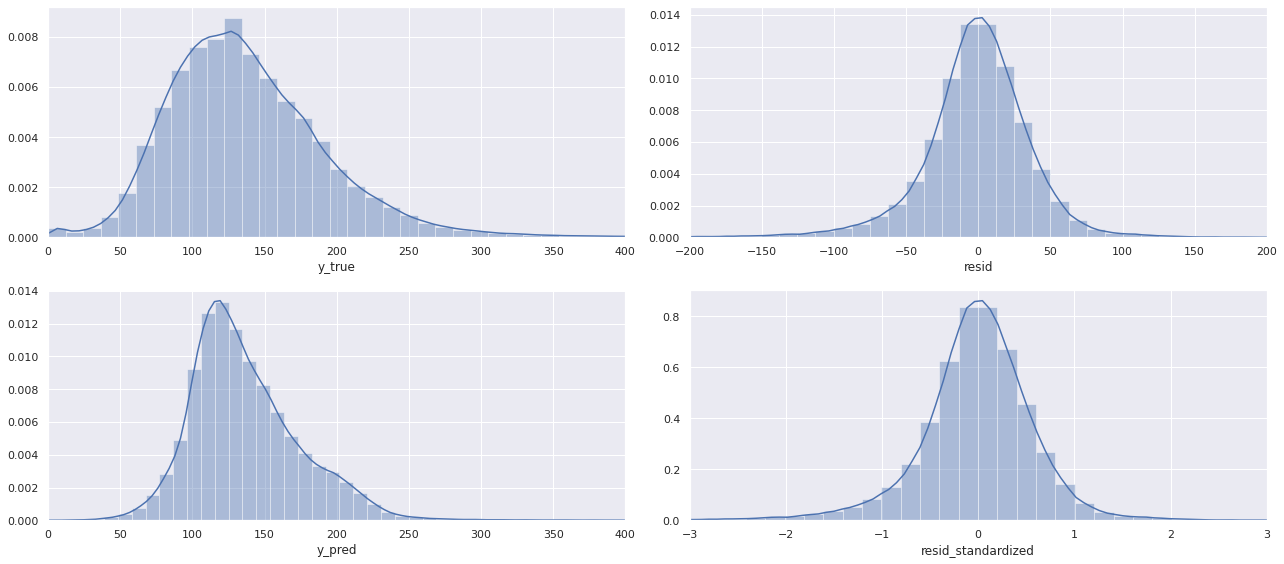

In [40]:
#@title Y0 Residual Distributions
display_resid_distrib(i=0, y_lim=(0, 400), res_lim=(-200,200))

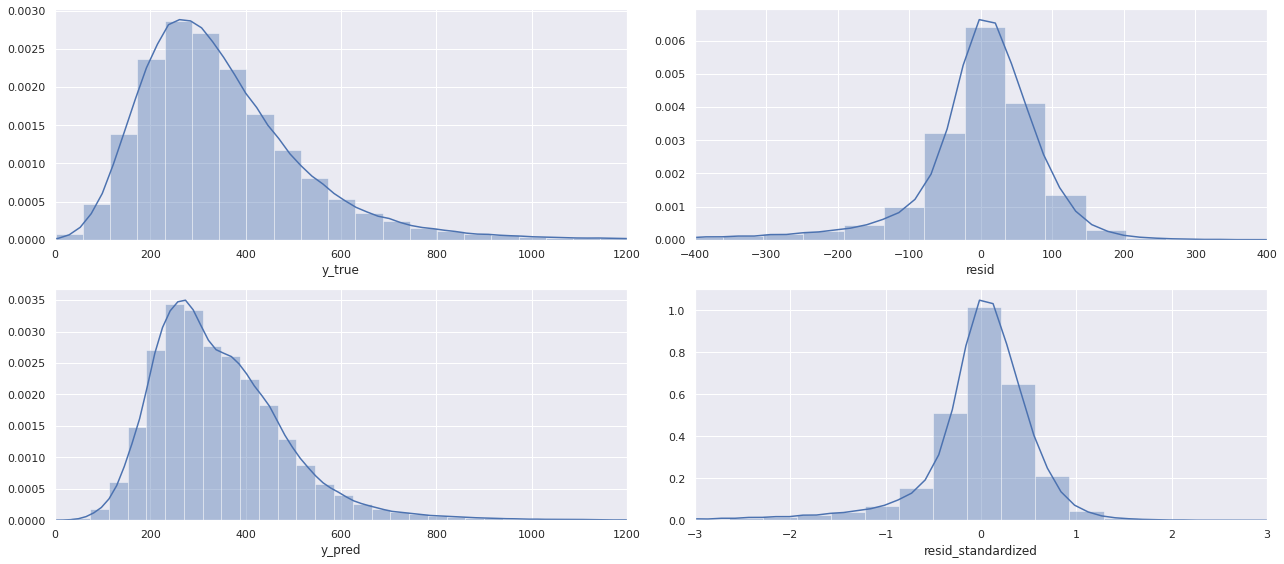

In [41]:
#@title Y1 Residual Distributions
display_resid_distrib(i=1, y_lim=(0, 1200), res_lim=(-400,400))

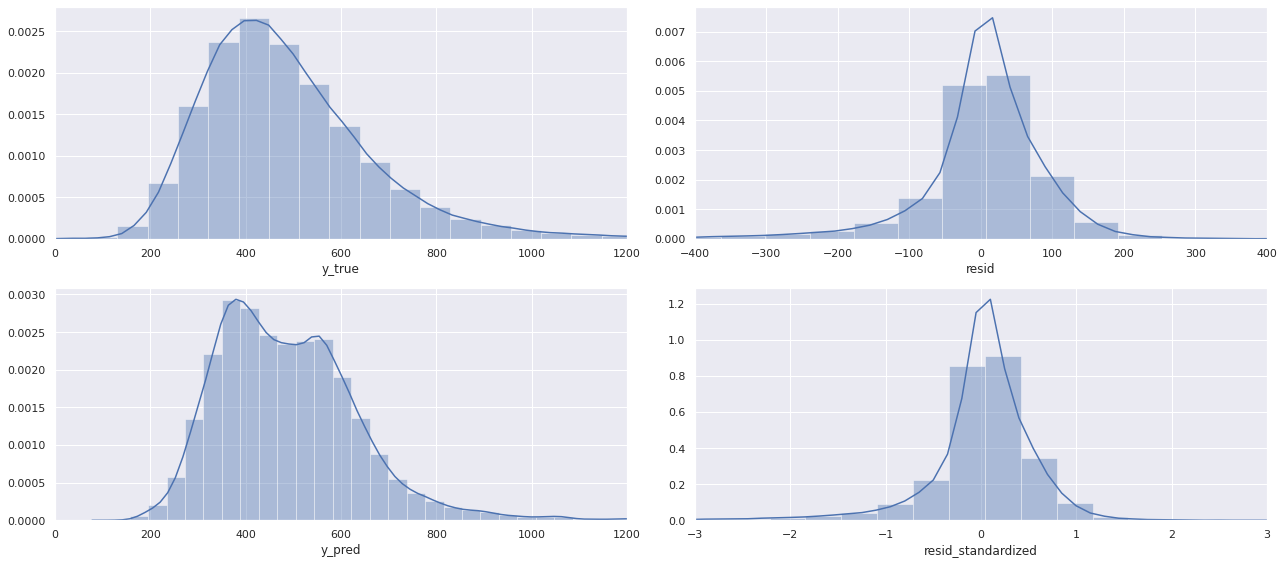

In [42]:
#@title Y2 Residual Distributions
display_resid_distrib(i=2, y_lim=(0, 1200), res_lim=(-400,400))

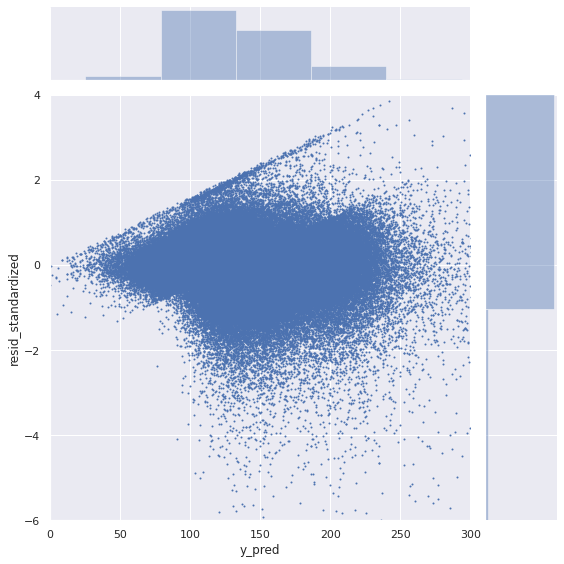

In [43]:
#@title Y0 predicted vs standardized residuals
sns.jointplot(x='y_pred', y='resid_standardized', 
              data=res_dfs[0], s=1, 
              xlim=(0,300), ylim=(-6,4), height=8)
# Heteroscedasticity

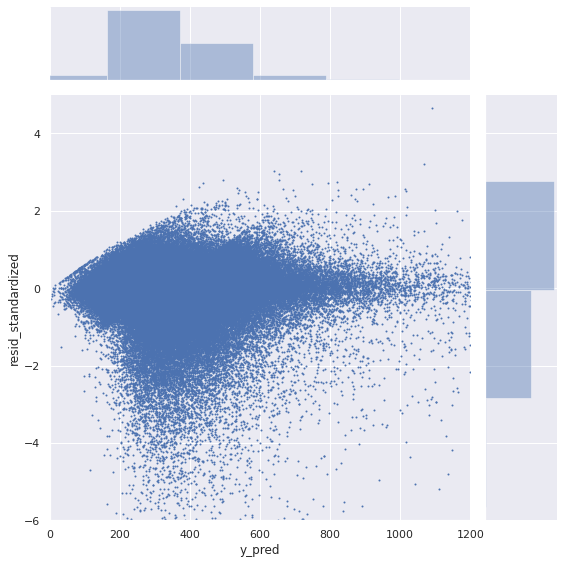

In [44]:
#@title Y1 predicted vs standardized residuals
sns.jointplot(x='y_pred', y='resid_standardized', data=res_dfs[1], s=1, 
              xlim=(0,1200), ylim=(-6,5), height=8)
# Heteroscedasticity

((array([-4.51528194, -4.32362428, -4.21962231, ...,  4.21962231,
          4.32362428,  4.51528194]),
  array([-338.31920469, -338.09190447, -337.89769789, ...,  265.97769326,
          278.65255193,  288.10428126])),
 (37.07324460665989, -1.3803044972843224, 0.9682763042529271))

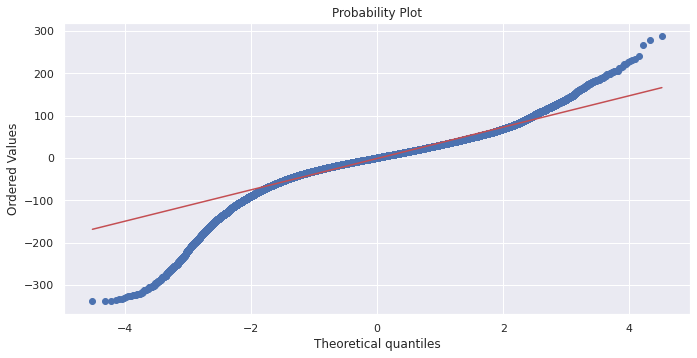

In [45]:
#@title Y0 residuals QQPlot
from scipy import stats
plt.figure(figsize=(10,5))
stats.probplot(res_dfs[0].sort_values('resid')[100:].resid, 
               plot=sns.mpl.pyplot)

((array([-4.51528194, -4.32362428, -4.21962231, ...,  4.21962231,
          4.32362428,  4.51528194]),
  array([-1941.1744088 , -1931.45500633, -1929.02803831, ...,
           795.15357856,   807.4214623 ,   880.22476928])),
 (96.44170228026364, -6.222561302809852, 0.8591554818553194))

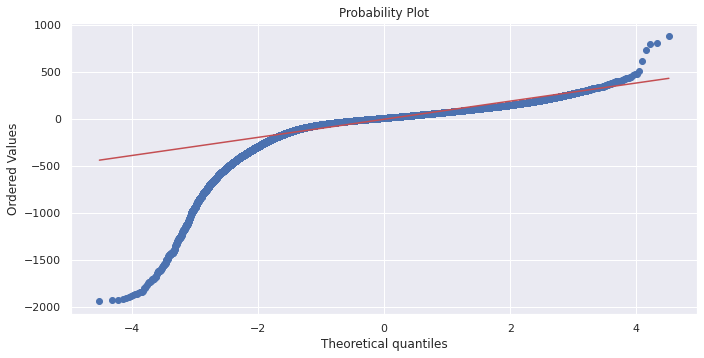

In [46]:
#@title Y1 residuals QQPlot
from scipy import stats
plt.figure(figsize=(10,5))
stats.probplot(res_dfs[1].sort_values('resid')[100:].resid, 
               plot=sns.mpl.pyplot)